In [1]:
from ARRG_macro import *

In [2]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [3]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [4]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
sim_accept_reject_PATH = '../pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '../pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(25000)

# Extract the hadron multiplicity
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])

# Convert into torch objects
sim_mult          = torch.Tensor(sim_mult[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_fPrel            = torch.Tensor(sim_fPrel[0:N_events].copy())
exp_mult          = torch.Tensor(exp_mult[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_mult.shape)
print('Simulated multiplicity shape:', sim_mult.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Prepare data for DataLoader
sim_mult          = ObservableDataset(sim_mult)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_fPrel)
exp_mult          = ObservableDataset(exp_mult)

Experimental observable shape: (100000, 75, 5)
Simulated observable shape: (100000, 75, 5)
Simulated z shape: (50000, 105, 101)
Simulated fPrel shape: (50000, 105, 100)
Experimental multiplicity shape: torch.Size([25000])
Simulated multiplicity shape: torch.Size([25000])
Simulated z shape: torch.Size([25000, 105, 101])
Simulated fPrel shape: torch.Size([25000, 105, 100])


In [5]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_mult,          batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_fPrel_dataloader         = DataLoader(sim_fPrel,         batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_mult,          batch_size = batch_size, shuffle = False)

In [6]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_fPrel_dataloader:', len(sim_fPrel_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 25000
Size of sim_accept_reject_dataloader: 25000
Size of sim_fPrel_dataloader: 25000
Size of exp_observable_dataloader: 25000


In [7]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate
learning_rate = 0.01
fixed_binning = True
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6-0.1, 0.80+0.1)#(0.6, 0.80)
b_range  = (0.85-0.1, 1.05+0.1)#(0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 105
Each emission has been zero-padded to a length of 101


In [8]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([100, 2])


In [9]:
# Irrelevant parameters for the flow plot that must be initialized for the ARRG class
epochs = 1
learning_rate = 0.01

# Create an ARRG instance
ARRG = ARRG(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
			params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_z_dataloader = sim_accept_reject_dataloader, 
			sim_fPrel_dataloader = sim_fPrel_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
			results_dir = None, params_init = None, fixed_binning = True)

In [10]:
# Set the optimizer
optimizer = torch.optim.Adam(ARRG.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients!
a_b_gradients, loss_grid = ARRG.ARRG_flow(optimizer, a_b_init)

  0%|                                                                       | 0/100 [00:00<?, ?it/s]/global/homes/t/tmenzo/.conda/envs/py311/lib/python3.11/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403238793/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  cws = cws.T.contiguous()
  1%|▋                                                              | 1/100 [00:09<14:51,  9.01s/it]

----------------------------------------------
Loss: 0.15681323
a: 0.5
Gradient of a: -1.0700622
b: 0.75
Gradient of b: 0.1184234
----------------------------------------------


  2%|█▎                                                             | 2/100 [00:18<15:06,  9.25s/it]

----------------------------------------------
Loss: 0.23321538
a: 0.5
Gradient of a: -5.2025394
b: 0.79444444
Gradient of b: 3.5916457
----------------------------------------------


  3%|█▉                                                             | 3/100 [00:27<14:28,  8.95s/it]

----------------------------------------------
Loss: 0.41332334
a: 0.5
Gradient of a: -6.0885854
b: 0.8388889
Gradient of b: 4.3287983
----------------------------------------------


  4%|██▌                                                            | 4/100 [00:35<14:13,  8.89s/it]

----------------------------------------------
Loss: 0.6036132
a: 0.5
Gradient of a: -6.0501304
b: 0.8833333
Gradient of b: 4.1795316
----------------------------------------------


  5%|███▏                                                           | 5/100 [00:44<13:47,  8.71s/it]

----------------------------------------------
Loss: 0.78481364
a: 0.5
Gradient of a: -5.949193
b: 0.92777777
Gradient of b: 3.978076
----------------------------------------------


  6%|███▊                                                           | 6/100 [00:53<13:51,  8.84s/it]

----------------------------------------------
Loss: 0.9574963
a: 0.5
Gradient of a: -5.8527
b: 0.9722222
Gradient of b: 3.7954981
----------------------------------------------


  7%|████▍                                                          | 7/100 [01:02<13:38,  8.80s/it]

----------------------------------------------
Loss: 1.1224111
a: 0.5
Gradient of a: -5.7590246
b: 1.0166667
Gradient of b: 3.6278172
----------------------------------------------


  8%|█████                                                          | 8/100 [01:11<13:41,  8.93s/it]

----------------------------------------------
Loss: 1.2801459
a: 0.5
Gradient of a: -5.6668706
b: 1.0611111
Gradient of b: 3.472031
----------------------------------------------


  9%|█████▋                                                         | 9/100 [01:20<13:34,  8.95s/it]

----------------------------------------------
Loss: 1.4311744
a: 0.5
Gradient of a: -5.5751286
b: 1.1055555
Gradient of b: 3.3256288
----------------------------------------------


 10%|██████▏                                                       | 10/100 [01:28<13:18,  8.87s/it]

----------------------------------------------
Loss: 1.5758673
a: 0.5
Gradient of a: -5.483011
b: 1.15
Gradient of b: 3.1866455
----------------------------------------------


 11%|██████▊                                                       | 11/100 [01:37<13:11,  8.90s/it]

----------------------------------------------
Loss: 0.29955137
a: 0.54444444
Gradient of a: 5.7271895
b: 0.75
Gradient of b: -4.830513
----------------------------------------------


 12%|███████▍                                                      | 12/100 [01:46<12:55,  8.81s/it]

----------------------------------------------
Loss: 0.1260405
a: 0.54444444
Gradient of a: 0.43366683
b: 0.79444444
Gradient of b: -1.0367775
----------------------------------------------


 13%|████████                                                      | 13/100 [01:55<12:49,  8.84s/it]

----------------------------------------------
Loss: 0.16458336
a: 0.54444444
Gradient of a: -4.436203
b: 0.8388889
Gradient of b: 2.938326
----------------------------------------------


 14%|████████▋                                                     | 14/100 [02:04<12:42,  8.86s/it]

----------------------------------------------
Loss: 0.3363981
a: 0.54444444
Gradient of a: -5.9576473
b: 0.8833333
Gradient of b: 4.253618
----------------------------------------------


 15%|█████████▎                                                    | 15/100 [02:13<12:36,  8.90s/it]

----------------------------------------------
Loss: 0.52181697
a: 0.54444444
Gradient of a: -5.8686466
b: 0.92777777
Gradient of b: 4.0574794
----------------------------------------------


 16%|█████████▉                                                    | 16/100 [02:22<12:25,  8.87s/it]

----------------------------------------------
Loss: 0.69868094
a: 0.54444444
Gradient of a: -5.7929068
b: 0.9722222
Gradient of b: 3.8876662
----------------------------------------------


 17%|██████████▌                                                   | 17/100 [02:31<12:21,  8.94s/it]

----------------------------------------------
Loss: 0.86763036
a: 0.54444444
Gradient of a: -5.704898
b: 1.0166667
Gradient of b: 3.7174082
----------------------------------------------


 18%|███████████▏                                                  | 18/100 [02:39<12:04,  8.84s/it]

----------------------------------------------
Loss: 1.0293117
a: 0.54444444
Gradient of a: -5.619262
b: 1.0611111
Gradient of b: 3.5602942
----------------------------------------------


 19%|███████████▊                                                  | 19/100 [02:48<11:56,  8.84s/it]

----------------------------------------------
Loss: 1.1842544
a: 0.54444444
Gradient of a: -5.5347686
b: 1.1055555
Gradient of b: 3.4136608
----------------------------------------------


 20%|████████████▍                                                 | 20/100 [02:57<11:57,  8.97s/it]

----------------------------------------------
Loss: 1.3328717
a: 0.54444444
Gradient of a: -5.450342
b: 1.15
Gradient of b: 3.275217
----------------------------------------------


 21%|█████████████                                                 | 21/100 [03:07<11:51,  9.01s/it]

----------------------------------------------
Loss: 0.56776905
a: 0.5888889
Gradient of a: 6.2760234
b: 0.75
Gradient of b: -5.26194
----------------------------------------------


 22%|█████████████▋                                                | 22/100 [03:15<11:34,  8.90s/it]

----------------------------------------------
Loss: 0.3424195
a: 0.5888889
Gradient of a: 6.026915
b: 0.79444444
Gradient of b: -4.8726435
----------------------------------------------


 23%|██████████████▎                                               | 23/100 [03:24<11:21,  8.85s/it]

----------------------------------------------
Loss: 0.13977191
a: 0.5888889
Gradient of a: 5.4163203
b: 0.8388889
Gradient of b: -4.3526745
----------------------------------------------


 24%|██████████████▉                                               | 24/100 [03:33<11:11,  8.84s/it]

----------------------------------------------
Loss: 0.10085615
a: 0.5888889
Gradient of a: -3.4487643
b: 0.8833333
Gradient of b: 2.1289086
----------------------------------------------


 25%|███████████████▌                                              | 25/100 [03:42<11:04,  8.86s/it]

----------------------------------------------
Loss: 0.26191044
a: 0.5888889
Gradient of a: -5.7943196
b: 0.92777777
Gradient of b: 4.1594777
----------------------------------------------


 26%|████████████████                                              | 26/100 [03:51<11:05,  8.99s/it]

----------------------------------------------
Loss: 0.44266766
a: 0.5888889
Gradient of a: -5.726805
b: 0.9722222
Gradient of b: 3.9751086
----------------------------------------------


 27%|████████████████▋                                             | 27/100 [04:00<11:03,  9.08s/it]

----------------------------------------------
Loss: 0.61541575
a: 0.5888889
Gradient of a: -5.643504
b: 1.0166667
Gradient of b: 3.8013468
----------------------------------------------


 28%|█████████████████▎                                            | 28/100 [04:09<10:56,  9.12s/it]

----------------------------------------------
Loss: 0.7807784
a: 0.5888889
Gradient of a: -5.5634775
b: 1.0611111
Gradient of b: 3.642061
----------------------------------------------


 29%|█████████████████▉                                            | 29/100 [04:18<10:43,  9.06s/it]

----------------------------------------------
Loss: 0.9393288
a: 0.5888889
Gradient of a: -5.485436
b: 1.1055555
Gradient of b: 3.4944642
----------------------------------------------


 30%|██████████████████▌                                           | 30/100 [04:27<10:31,  9.02s/it]

----------------------------------------------
Loss: 1.091533
a: 0.5888889
Gradient of a: -4.7976522
b: 1.15
Gradient of b: 3.0151668
----------------------------------------------


 31%|███████████████████▏                                          | 31/100 [04:36<10:18,  8.96s/it]

----------------------------------------------
Loss: 0.84517187
a: 0.6333333
Gradient of a: 6.2069225
b: 0.75
Gradient of b: -5.4109187
----------------------------------------------


 32%|███████████████████▊                                          | 32/100 [04:45<10:12,  9.01s/it]

----------------------------------------------
Loss: 0.61276793
a: 0.6333333
Gradient of a: 6.0661
b: 0.79444444
Gradient of b: -5.0554037
----------------------------------------------


 33%|████████████████████▍                                         | 33/100 [04:54<09:54,  8.88s/it]

----------------------------------------------
Loss: 0.39506856
a: 0.6333333
Gradient of a: 5.943708
b: 0.8388889
Gradient of b: -4.749095
----------------------------------------------


 34%|█████████████████████                                         | 34/100 [05:03<09:51,  8.96s/it]

----------------------------------------------
Loss: 0.19050798
a: 0.6333333
Gradient of a: 5.728596
b: 0.8833333
Gradient of b: -4.437413
----------------------------------------------


 35%|█████████████████████▋                                        | 35/100 [05:12<09:42,  8.96s/it]

----------------------------------------------
Loss: 0.04578664
a: 0.6333333
Gradient of a: -1.0400621
b: 0.92777777
Gradient of b: 0.2098493
----------------------------------------------


 36%|██████████████████████▎                                       | 36/100 [05:21<09:34,  8.98s/it]

----------------------------------------------
Loss: 0.19044021
a: 0.6333333
Gradient of a: -5.5648785
b: 0.9722222
Gradient of b: 3.9841275
----------------------------------------------


 37%|██████████████████████▉                                       | 37/100 [05:30<09:23,  8.94s/it]

----------------------------------------------
Loss: 0.36648852
a: 0.6333333
Gradient of a: -5.5587816
b: 1.0166667
Gradient of b: 3.8755512
----------------------------------------------


 38%|███████████████████████▌                                      | 38/100 [05:39<09:12,  8.91s/it]

----------------------------------------------
Loss: 0.5351168
a: 0.6333333
Gradient of a: -5.4832516
b: 1.0611111
Gradient of b: 3.714117
----------------------------------------------


 39%|████████████████████████▏                                     | 39/100 [05:47<08:59,  8.85s/it]

----------------------------------------------
Loss: 0.69682354
a: 0.6333333
Gradient of a: -5.409634
b: 1.1055555
Gradient of b: 3.5646107
----------------------------------------------


 40%|████████████████████████▊                                     | 40/100 [05:56<08:47,  8.80s/it]

----------------------------------------------
Loss: 0.8522799
a: 0.6333333
Gradient of a: -5.356739
b: 1.15
Gradient of b: 3.4299288
----------------------------------------------


 41%|█████████████████████████▍                                    | 41/100 [06:05<08:43,  8.87s/it]

----------------------------------------------
Loss: 1.1194766
a: 0.67777777
Gradient of a: 6.136474
b: 0.75
Gradient of b: -5.5629697
----------------------------------------------


 42%|██████████████████████████                                    | 42/100 [06:14<08:27,  8.75s/it]

----------------------------------------------
Loss: 0.88074815
a: 0.67777777
Gradient of a: 5.9928217
b: 0.79444444
Gradient of b: -5.18793
----------------------------------------------


 43%|██████████████████████████▋                                   | 43/100 [06:23<08:25,  8.86s/it]

----------------------------------------------
Loss: 0.6575632
a: 0.67777777
Gradient of a: 5.8683114
b: 0.8388889
Gradient of b: -4.8639216
----------------------------------------------


 44%|███████████████████████████▎                                  | 44/100 [06:32<08:16,  8.87s/it]

----------------------------------------------
Loss: 0.44769007
a: 0.67777777
Gradient of a: 5.7604423
b: 0.8833333
Gradient of b: -4.587667
----------------------------------------------


 45%|███████████████████████████▉                                  | 45/100 [06:41<08:16,  9.03s/it]

----------------------------------------------
Loss: 0.24919298
a: 0.67777777
Gradient of a: 5.665704
b: 0.92777777
Gradient of b: -4.350346
----------------------------------------------


 46%|████████████████████████████▌                                 | 46/100 [06:50<08:05,  9.00s/it]

----------------------------------------------
Loss: 0.061091524
a: 0.67777777
Gradient of a: 4.2416854
b: 0.9722222
Gradient of b: -3.1732163
----------------------------------------------


 47%|█████████████████████████████▏                                | 47/100 [06:59<07:56,  8.99s/it]

----------------------------------------------
Loss: 0.12127693
a: 0.67777777
Gradient of a: -5.4166765
b: 1.0166667
Gradient of b: 3.8848438
----------------------------------------------


 48%|█████████████████████████████▊                                | 48/100 [07:08<07:49,  9.02s/it]

----------------------------------------------
Loss: 0.2928428
a: 0.67777777
Gradient of a: -5.418056
b: 1.0611111
Gradient of b: 3.7867455
----------------------------------------------


 49%|██████████████████████████████▍                               | 49/100 [07:17<07:39,  9.00s/it]

----------------------------------------------
Loss: 0.4577146
a: 0.67777777
Gradient of a: -5.349036
b: 1.1055555
Gradient of b: 3.6346424
----------------------------------------------


 50%|███████████████████████████████                               | 50/100 [07:26<07:30,  9.02s/it]

----------------------------------------------
Loss: 0.6160927
a: 0.67777777
Gradient of a: -5.2824073
b: 1.15
Gradient of b: 3.4941401
----------------------------------------------


 51%|███████████████████████████████▌                              | 51/100 [07:35<07:18,  8.95s/it]

----------------------------------------------
Loss: 1.3906113
a: 0.7222222
Gradient of a: 6.0643497
b: 0.75
Gradient of b: -5.717182
----------------------------------------------


 52%|████████████████████████████████▏                             | 52/100 [07:44<07:10,  8.97s/it]

----------------------------------------------
Loss: 1.1454492
a: 0.7222222
Gradient of a: 5.918563
b: 0.79444444
Gradient of b: -5.3230343
----------------------------------------------


 53%|████████████████████████████████▊                             | 53/100 [07:53<06:59,  8.92s/it]

----------------------------------------------
Loss: 0.9166819
a: 0.7222222
Gradient of a: 5.7918515
b: 0.8388889
Gradient of b: -4.9804516
----------------------------------------------


 54%|█████████████████████████████████▍                            | 54/100 [08:02<06:52,  8.97s/it]

----------------------------------------------
Loss: 0.70198566
a: 0.7222222
Gradient of a: 5.682687
b: 0.8833333
Gradient of b: -4.688717
----------------------------------------------


 55%|██████████████████████████████████                            | 55/100 [08:11<06:45,  9.02s/it]

----------------------------------------------
Loss: 0.49927822
a: 0.7222222
Gradient of a: 5.587759
b: 0.92777777
Gradient of b: -4.439448
----------------------------------------------


 56%|██████████████████████████████████▋                           | 56/100 [08:20<06:36,  9.01s/it]

----------------------------------------------
Loss: 0.3068812
a: 0.7222222
Gradient of a: 5.503706
b: 0.9722222
Gradient of b: -4.223074
----------------------------------------------


 57%|███████████████████████████████████▎                          | 57/100 [08:29<06:28,  9.04s/it]

----------------------------------------------
Loss: 0.12369649
a: 0.7222222
Gradient of a: 5.423694
b: 1.0166667
Gradient of b: -4.026844
----------------------------------------------


 58%|███████████████████████████████████▉                          | 58/100 [08:38<06:16,  8.96s/it]

----------------------------------------------
Loss: 0.07264261
a: 0.7222222
Gradient of a: -2.5899928
b: 1.0611111
Gradient of b: 2.2715375
----------------------------------------------


 59%|████████████████████████████████████▌                         | 59/100 [08:47<06:09,  9.01s/it]

----------------------------------------------
Loss: 0.22144672
a: 0.7222222
Gradient of a: -5.282103
b: 1.1055555
Gradient of b: 3.7002144
----------------------------------------------


 60%|█████████████████████████████████████▏                        | 60/100 [08:56<06:00,  9.00s/it]

----------------------------------------------
Loss: 0.38268763
a: 0.7222222
Gradient of a: -5.219785
b: 1.15
Gradient of b: 3.5575383
----------------------------------------------


 61%|█████████████████████████████████████▊                        | 61/100 [09:05<05:48,  8.94s/it]

----------------------------------------------
Loss: 1.6584927
a: 0.76666665
Gradient of a: 5.9898076
b: 0.75
Gradient of b: -5.8717556
----------------------------------------------


 62%|██████████████████████████████████████▍                       | 62/100 [09:13<05:35,  8.84s/it]

----------------------------------------------
Loss: 1.4068284
a: 0.76666665
Gradient of a: 5.843327
b: 0.79444444
Gradient of b: -5.4602385
----------------------------------------------


 63%|███████████████████████████████████████                       | 63/100 [09:22<05:29,  8.89s/it]

----------------------------------------------
Loss: 1.1723865
a: 0.76666665
Gradient of a: 5.7147675
b: 0.8388889
Gradient of b: -5.098814
----------------------------------------------


 64%|███████████████████████████████████████▋                      | 64/100 [09:31<05:21,  8.92s/it]

----------------------------------------------
Loss: 0.9528065
a: 0.76666665
Gradient of a: 5.60417
b: 0.8833333
Gradient of b: -4.790668
----------------------------------------------


 65%|████████████████████████████████████████▎                     | 65/100 [09:40<05:14,  8.97s/it]

----------------------------------------------
Loss: 0.7458683
a: 0.76666665
Gradient of a: 5.5086904
b: 0.92777777
Gradient of b: -4.528433
----------------------------------------------


 66%|████████████████████████████████████████▉                     | 66/100 [09:50<05:09,  9.11s/it]

----------------------------------------------
Loss: 0.5497459
a: 0.76666665
Gradient of a: 5.424994
b: 0.9722222
Gradient of b: -4.302241
----------------------------------------------


 67%|█████████████████████████████████████████▌                    | 67/100 [09:58<04:56,  8.98s/it]

----------------------------------------------
Loss: 0.36304015
a: 0.76666665
Gradient of a: 5.3502245
b: 1.0166667
Gradient of b: -4.1035576
----------------------------------------------


 68%|██████████████████████████████████████████▏                   | 68/100 [10:07<04:48,  9.02s/it]

----------------------------------------------
Loss: 0.18487918
a: 0.76666665
Gradient of a: 5.278431
b: 1.0611111
Gradient of b: -3.9216661
----------------------------------------------


 69%|██████████████████████████████████████████▊                   | 69/100 [10:17<04:41,  9.08s/it]

----------------------------------------------
Loss: 0.06915208
a: 0.76666665
Gradient of a: -1.4644213
b: 1.1055555
Gradient of b: 1.5119517
----------------------------------------------


 70%|███████████████████████████████████████████▍                  | 70/100 [10:26<04:34,  9.14s/it]

----------------------------------------------
Loss: 0.16820829
a: 0.76666665
Gradient of a: -4.189332
b: 1.15
Gradient of b: 3.1537476
----------------------------------------------


 71%|████████████████████████████████████████████                  | 71/100 [10:35<04:21,  9.01s/it]

----------------------------------------------
Loss: 1.9230037
a: 0.8111111
Gradient of a: 5.912285
b: 0.75
Gradient of b: -6.0242295
----------------------------------------------


 72%|████████████████████████████████████████████▋                 | 72/100 [10:43<04:10,  8.94s/it]

----------------------------------------------
Loss: 1.6648464
a: 0.8111111
Gradient of a: 5.7672815
b: 0.79444444
Gradient of b: -5.5986094
----------------------------------------------


 73%|█████████████████████████████████████████████▎                | 73/100 [10:52<04:00,  8.90s/it]

----------------------------------------------
Loss: 1.424657
a: 0.8111111
Gradient of a: 5.63777
b: 0.8388889
Gradient of b: -5.218943
----------------------------------------------


 74%|█████████████████████████████████████████████▉                | 74/100 [11:01<03:50,  8.87s/it]

----------------------------------------------
Loss: 1.200129
a: 0.8111111
Gradient of a: 5.5253525
b: 0.8833333
Gradient of b: -4.893675
----------------------------------------------


 75%|██████████████████████████████████████████████▌               | 75/100 [11:10<03:41,  8.85s/it]

----------------------------------------------
Loss: 0.98893094
a: 0.8111111
Gradient of a: 5.429173
b: 0.92777777
Gradient of b: -4.6176414
----------------------------------------------


 76%|███████████████████████████████████████████████               | 76/100 [11:19<03:33,  8.91s/it]

----------------------------------------------
Loss: 0.7890946
a: 0.8111111
Gradient of a: 5.3455224
b: 0.9722222
Gradient of b: -4.380828
----------------------------------------------


 77%|███████████████████████████████████████████████▋              | 77/100 [11:28<03:25,  8.93s/it]

----------------------------------------------
Loss: 0.5990801
a: 0.8111111
Gradient of a: 5.2714987
b: 1.0166667
Gradient of b: -4.1740737
----------------------------------------------


 78%|████████████████████████████████████████████████▎             | 78/100 [11:37<03:14,  8.86s/it]

----------------------------------------------
Loss: 0.41774017
a: 0.8111111
Gradient of a: 5.200078
b: 1.0611111
Gradient of b: -3.9847028
----------------------------------------------


 79%|████████████████████████████████████████████████▉             | 79/100 [11:45<03:05,  8.84s/it]

----------------------------------------------
Loss: 0.24433309
a: 0.8111111
Gradient of a: 5.140391
b: 1.1055555
Gradient of b: -3.8213334
----------------------------------------------


 80%|█████████████████████████████████████████████████▌            | 80/100 [11:54<02:57,  8.87s/it]

----------------------------------------------
Loss: 0.08662978
a: 0.8111111
Gradient of a: 2.0908422
b: 1.15
Gradient of b: -1.1485176
----------------------------------------------


 81%|██████████████████████████████████████████████████▏           | 81/100 [12:03<02:50,  8.98s/it]

----------------------------------------------
Loss: 2.1839545
a: 0.85555553
Gradient of a: 5.829708
b: 0.75
Gradient of b: -6.171182
----------------------------------------------


 82%|██████████████████████████████████████████████████▊           | 82/100 [12:13<02:43,  9.06s/it]

----------------------------------------------
Loss: 1.9194324
a: 0.85555553
Gradient of a: 5.68872
b: 0.79444444
Gradient of b: -5.7361374
----------------------------------------------


 83%|███████████████████████████████████████████████████▍          | 83/100 [12:22<02:35,  9.13s/it]

----------------------------------------------
Loss: 1.6734874
a: 0.85555553
Gradient of a: 5.559535
b: 0.8388889
Gradient of b: -5.3398657
----------------------------------------------


 84%|████████████████████████████████████████████████████          | 84/100 [12:31<02:24,  9.04s/it]

----------------------------------------------
Loss: 1.4439652
a: 0.85555553
Gradient of a: 5.4468975
b: 0.8833333
Gradient of b: -4.997774
----------------------------------------------


 85%|████████████████████████████████████████████████████▋         | 85/100 [12:40<02:15,  9.05s/it]

----------------------------------------------
Loss: 1.228471
a: 0.85555553
Gradient of a: 5.2638574
b: 0.92777777
Gradient of b: -4.6080823
----------------------------------------------


 86%|█████████████████████████████████████████████████████▎        | 86/100 [12:49<02:05,  8.98s/it]

----------------------------------------------
Loss: 1.0249068
a: 0.85555553
Gradient of a: 5.2664013
b: 0.9722222
Gradient of b: -4.4592605
----------------------------------------------


 87%|█████████████████████████████████████████████████████▉        | 87/100 [12:58<01:56,  8.98s/it]

----------------------------------------------
Loss: 0.83161265
a: 0.85555553
Gradient of a: 5.192348
b: 1.0166667
Gradient of b: -4.2436895
----------------------------------------------


 88%|██████████████████████████████████████████████████████▌       | 88/100 [13:07<01:47,  8.95s/it]

----------------------------------------------
Loss: 0.64731246
a: 0.85555553
Gradient of a: 5.1267147
b: 1.0611111
Gradient of b: -4.0534377
----------------------------------------------


 89%|███████████████████████████████████████████████████████▏      | 89/100 [13:15<01:37,  8.88s/it]

----------------------------------------------
Loss: 0.47107655
a: 0.85555553
Gradient of a: 5.062835
b: 1.1055555
Gradient of b: -3.877772
----------------------------------------------


 90%|███████████████████████████████████████████████████████▊      | 90/100 [13:24<01:28,  8.86s/it]

----------------------------------------------
Loss: 0.30216783
a: 0.85555553
Gradient of a: 5.009431
b: 1.15
Gradient of b: -3.7255147
----------------------------------------------


 91%|████████████████████████████████████████████████████████▍     | 91/100 [13:33<01:19,  8.84s/it]

----------------------------------------------
Loss: 2.4411237
a: 0.9
Gradient of a: 5.7419147
b: 0.75
Gradient of b: -6.309617
----------------------------------------------


 92%|█████████████████████████████████████████████████████████     | 92/100 [13:42<01:11,  8.94s/it]

----------------------------------------------
Loss: 2.1704738
a: 0.9
Gradient of a: 5.607668
b: 0.79444444
Gradient of b: -5.870907
----------------------------------------------


 93%|█████████████████████████████████████████████████████████▋    | 93/100 [13:51<01:02,  8.94s/it]

----------------------------------------------
Loss: 1.9188244
a: 0.9
Gradient of a: 5.0236588
b: 0.8388889
Gradient of b: -5.0631356
----------------------------------------------


 94%|██████████████████████████████████████████████████████████▎   | 94/100 [14:00<00:53,  8.95s/it]

----------------------------------------------
Loss: 1.6842935
a: 0.9
Gradient of a: 5.3678536
b: 0.8833333
Gradient of b: -5.1023607
----------------------------------------------


 95%|██████████████████████████████████████████████████████████▉   | 95/100 [14:09<00:44,  8.90s/it]

----------------------------------------------
Loss: 1.4644865
a: 0.9
Gradient of a: 5.2706428
b: 0.92777777
Gradient of b: -4.79727
----------------------------------------------


 96%|███████████████████████████████████████████████████████████▌  | 96/100 [14:18<00:35,  8.90s/it]

----------------------------------------------
Loss: 1.2571988
a: 0.9
Gradient of a: 5.186821
b: 0.9722222
Gradient of b: -4.5373607
----------------------------------------------


 97%|████████████████████████████████████████████████████████████▏ | 97/100 [14:27<00:26,  8.93s/it]

----------------------------------------------
Loss: 1.0606446
a: 0.9
Gradient of a: 5.1136746
b: 1.0166667
Gradient of b: -4.312752
----------------------------------------------


 98%|████████████████████████████████████████████████████████████▊ | 98/100 [14:36<00:18,  9.05s/it]

----------------------------------------------
Loss: 0.87344337
a: 0.9
Gradient of a: 5.048878
b: 1.0611111
Gradient of b: -4.1153264
----------------------------------------------


 99%|█████████████████████████████████████████████████████████████▍| 99/100 [14:45<00:08,  8.98s/it]

----------------------------------------------
Loss: 0.694521
a: 0.9
Gradient of a: 4.990686
b: 1.1055555
Gradient of b: -3.9394035
----------------------------------------------


100%|█████████████████████████████████████████████████████████████| 100/100 [14:54<00:00,  8.94s/it]

----------------------------------------------
Loss: 0.52311945
a: 0.9
Gradient of a: 4.933664
b: 1.15
Gradient of b: -3.7760966
----------------------------------------------


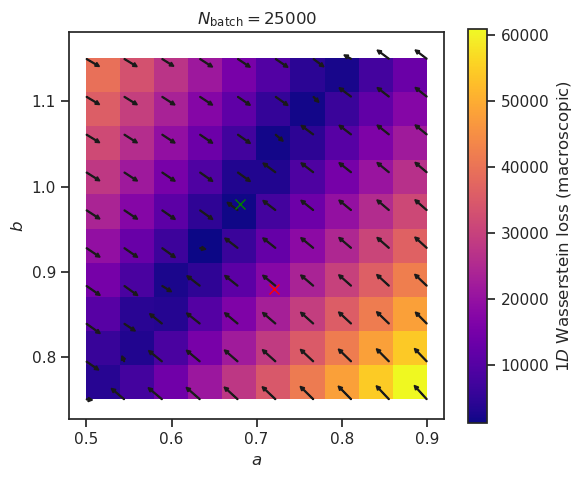

In [13]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((loss_grid * N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'$1D$ Wasserstein loss (macroscopic)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/5e2, -gradient[1]/5e2, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_finalTwo_flow_wass1d_loss_fixed_bin_Nbatch_25e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_finalTwo_flow_wass1d_loss_fixed_bin_Nbatch_25e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

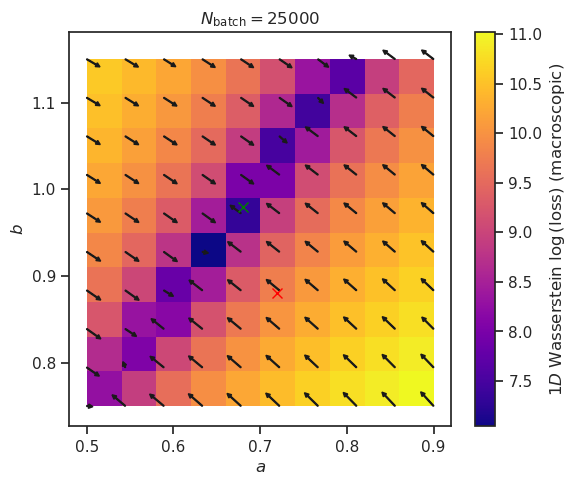

In [14]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((np.log(loss_grid * N_events)).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'$1D$ Wasserstein $\log$(loss) (macroscopic)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/5e2, -gradient[1]/5e2, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_wass1d_log_loss_fixed_bin_Nbatch_25e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_wass1d_log_loss_fixed_bin_Nbatch_25e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [12]:
# Save the (a,b) values, their gradients, and the loss grid
np.save('flow_data/flow_data_finalTwo_wass1d_a_b_Nbatch_25e3_fixed.npy', a_b)
np.save('flow_data/flow_data_finalTwo_wass1d_a_b_gradients_Nbatch_25e3_fixed.npy', a_b_gradients)
np.save('flow_data/flow_data_finalTwo_wass1d_losses_Nbatch_25e3_fixed.npy', loss_grid)

In [ ]:
# Loading previous flow map
a_b = np.load('flow_data/flow_data_a_b_Nbatch_5e3.npy')
a_b_gradients = np.load('flow_data/flow_data_a_b_gradients_Nbatch_5e3.npy')
loss_grid = np.load('flow_data/flow_data_losses_Nbatch_5e3.npy')